In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
from scipy.optimize import curve_fit

In [3]:
lambda_ = 2  # Poisson process parameter (mean number of parts broken per week)


def by_hour_trans_prob(old_state, new_state, action):
    global lambda_
    prob = 0
    if old_state[0] == 0:
        if new_state[0] == action and new_state[1] == 168:
            prob = 1
    elif old_state[0] != 0:
        if new_state[1] == 0 and new_state[0] > action:
            num_broken_parts = old_state[0] + action - new_state[0]
            prob = stats.poisson.pmf(num_broken_parts, lambda_)
        elif new_state[1] != 0 and new_state[0] == action:
            if new_state[1] != 168:
                s = 0
                for k in range(old_state[0]):
                    s += stats.poisson.pmf(k, (lambda_ / 168) * (168 - new_state[1])) * \
                          stats.poisson.sf(old_state[0] - k - 1, lambda_ / 168)
                prob = s
            elif new_state[1] == 168:
                prob = stats.poisson.sf(old_state[0] - 1, lambda_ / 168)
    return prob

In [4]:
def get_state_space(max_parts):
    ss = []
    for i in range(max_parts + 1):
        for j in range(169):  # j in 0 to 7
            if i == 0 and j == 0:
                continue
            ss.append((i, j))
    return np.array(ss)

In [5]:
def cost_func(action, new_s, d=200, ppu=100, hpu=0.8, spdh=100):
    if action == 0:
        ordering_cost = 0
    else:
        ordering_cost = d + ppu * action
    holding_and_shortage = new_s[0] * hpu + new_s[1] * spdh
    return ordering_cost + holding_and_shortage


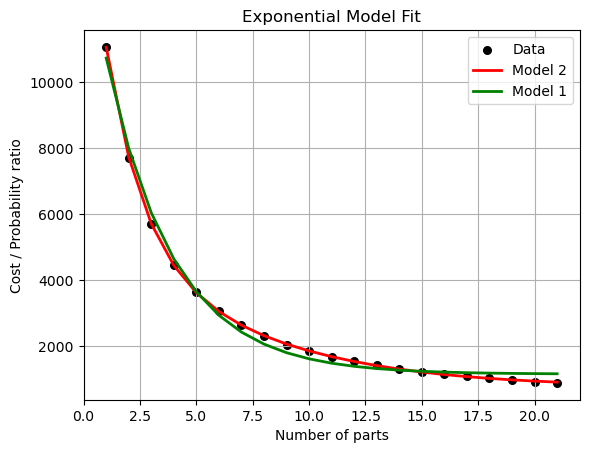

Parameters of model 1 (a * exp(-b * x) + c)
 [1.34260139e+04 3.36290544e-01 1.14924035e+03]
Parameters of model 2 (a * exp(-b * x) + d * x * exp(-e * x) + c)
 [1.59318618e+04 5.30270401e-01 1.18689579e+03 2.46565091e-01
 7.66674444e+02]


In [6]:
max_parts = 21
state_space = get_state_space(max_parts)

cost_matrix = np.empty((max_parts + 1, len(state_space)))
for a in range(max_parts + 1):
    for j, state in enumerate(state_space):
        cost_matrix[a, j] = cost_func(a, state)


ratios = []
x = np.arange(1, max_parts + 1)
for num_parts in x:
    cost = 0
    for j in range(1, 169):
        cost += by_hour_trans_prob((num_parts, 0), (0, j), 0) * \
                cost_func(0, (0, j))
    prob = stats.poisson.sf(num_parts - 1, lambda_)
    ratio = cost / prob if prob > 0 else np.nan
#   print(f"Number of starting parts: {num_parts}\nExpected cost: {cost}\n"
#         f"Probability of reaching zero: {prob}\nRatio: {ratio}\n")
    ratios.append(ratio)

x = x.astype(float)
y = np.array(ratios)

# First model: a * exp(-b * x) + c
def model1(x, a, b, c):
    return a * np.exp(-b * x) + c

# Second model: a * exp(-b * x) + d * x * exp(-e * x) + c
def model2(x, a, b, d, e, c):
    return a * np.exp(-b * x) + d * x * np.exp(-e * x) + c

popt1, _ = curve_fit(model1, x, y, p0=[10000, 0.2, 2000])
popt2, _ = curve_fit(model2, x, y, p0=[10000, 0.2, 1000, 0.1, 2000])

#
plt.scatter(x, y, label='Data', color='black', s=30)
plt.plot(x, model2(x, *popt2), color='red', linewidth=2, label='Model 2')
plt.plot(x, model1(x, *popt1), color='green', linewidth=2, label='Model 1')
plt.legend()
plt.xlabel("Number of parts")
plt.ylabel("Cost / Probability ratio")
plt.title("Exponential Model Fit")
plt.grid(True)
plt.show()

print("Parameters of model 1 (a * exp(-b * x) + c)\n", popt1)
print("Parameters of model 2 (a * exp(-b * x) + d * x * exp(-e * x) + c)\n", popt2)

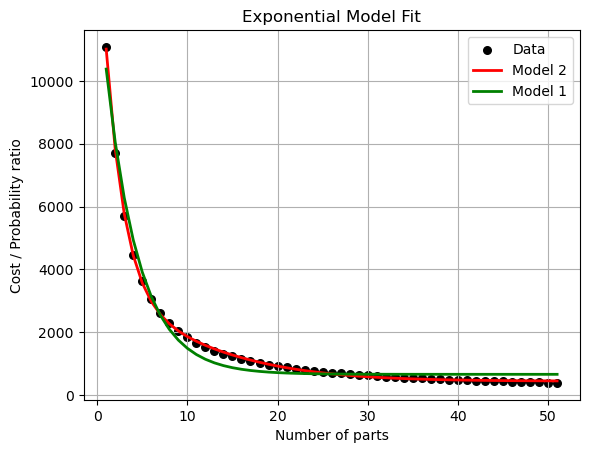

Parameters of model 1 (a * exp(-b * x) + c)
 [1.27682809e+04 2.73548721e-01 6.61590319e+02]
Parameters of model 2 (a * exp(-b * x) + d * x * exp(-e * x) + c)
 [1.55489663e+04 4.38185094e-01 6.27623689e+02 1.63502088e-01
 4.44530047e+02]


In [7]:
max_parts = 51
state_space = get_state_space(max_parts)

cost_matrix = np.empty((max_parts + 1, len(state_space)))
for a in range(max_parts + 1):
    for j, state in enumerate(state_space):
        cost_matrix[a, j] = cost_func(a, state)


ratios = []
x = np.arange(1, max_parts + 1)
for num_parts in x:
    cost = 0
    for j in range(1, 169):
        cost += by_hour_trans_prob((num_parts, 0), (0, j), 0) * \
                cost_func(0, (0, j))
    prob = stats.poisson.sf(num_parts - 1, lambda_)
    ratio = cost / prob if prob > 0 else np.nan
#   print(f"Number of starting parts: {num_parts}\nExpected cost: {cost}\n"
#         f"Probability of reaching zero: {prob}\nRatio: {ratio}\n")
    ratios.append(ratio)

x = x.astype(float)
y = np.array(ratios)

# First model: a * exp(-b * x) + c
def model1(x, a, b, c):
    return a * np.exp(-b * x) + c

# Second model: a * exp(-b * x) + d * x * exp(-e * x) + c
def model2(x, a, b, d, e, c):
    return a * np.exp(-b * x) + d * x * np.exp(-e * x) + c

popt1, _ = curve_fit(model1, x, y, p0=[10000, 0.2, 2000])
popt2, _ = curve_fit(model2, x, y, p0=[10000, 0.2, 1000, 0.1, 2000])

#
plt.scatter(x, y, label='Data', color='black', s=30)
plt.plot(x, model2(x, *popt2), color='red', linewidth=2, label='Model 2')
plt.plot(x, model1(x, *popt1), color='green', linewidth=2, label='Model 1')
plt.legend()
plt.xlabel("Number of parts")
plt.ylabel("Cost / Probability ratio")
plt.title("Exponential Model Fit")
plt.grid(True)
plt.show()

print("Parameters of model 1 (a * exp(-b * x) + c)\n", popt1)
print("Parameters of model 2 (a * exp(-b * x) + d * x * exp(-e * x) + c)\n", popt2)

In [8]:
def downtime_cost(num_parts, k=1680, lambda_=2, cost_per_week=16800):
    m = np.arange(1, k + 1)
    i = np.arange(num_parts)

    lambda_m = (lambda_ / k) * (k - m[:, None])
    pmf = stats.poisson.pmf(i[None, :], lambda_m)
    sf = stats.poisson.sf(num_parts - i - 1, lambda_ / k)

    prob = np.sum(pmf * sf, axis=1)
    weighted_cost = prob * (m / k) * cost_per_week
    total_cost = np.sum(weighted_cost)
    normalization = stats.poisson.sf(num_parts - 1, lambda_)

    return total_cost / normalization


list_of_nums = np.arange(1, 100, 2)
downtime_costs = []

for num in list_of_nums:
    downtime_costs.append(downtime_cost(num, k=604800))

downtime_costs = np.array(downtime_costs)



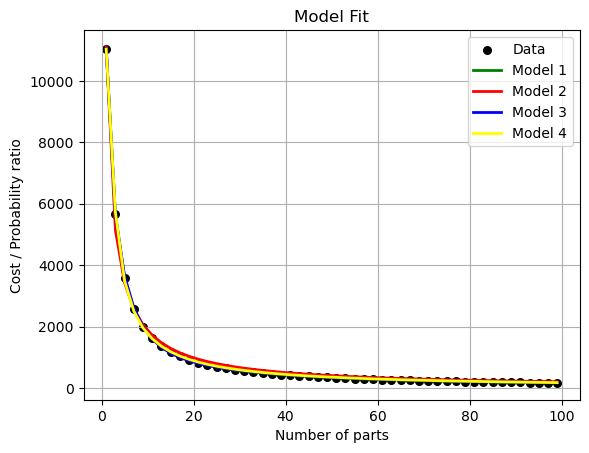

Parameters of model 1 (a * exp(-b * x) + c)
 [7.26871830e+02 1.96717159e-01 1.05016201e+04 1.64218971e+00
 1.27943139e-01]
Parameters of model 2 (degree 2 inverse polynomial with fixed intercept (0,16800))
 [20890.55902459  2003.54122284]
Parameters of model 3 (a * exp(-b * x) + c + d * x * exp(-e * x))
 [4.22260290e+03 2.76009362e-01 1.87632920e+04 6.22277532e+03]
Parameters of model 4 (degree 4 inverse polynomial with fixed intercept (0,16800))
 [18063.15826319 14265.80470526 -4672.3885505   1156.86270234]


In [9]:
x = list_of_nums
y = downtime_costs

def model1(x, a, b, c, e, f):
    return a * np.exp(-b * x) + c  * (np.sin(e / (x + f)))

def model2(x, a, b):
    return a / (x + a/16800) + b / ((x ** 2) + b/16800)

def model3(x, a, b, c, d):
    return a * np.exp(-b * x) + c / (x + 2 * c/(16800 - a)) + d / ((x ** 2) + 2 * d/(16800 - a))

def model4(x, a, b, c, d):
    return a / (x + a/16800) + b / ((x ** 2) + b/16800) + \
           c / ((x ** 3) + c/16800) + d / ((x ** 4) + d/16800)

popt1, _ = curve_fit(model1, x, y, p0=[10000, 0.2, 1000, 40, 40])
popt2, _ = curve_fit(model2, x, y, p0=[20000, 2000])
popt3, _ = curve_fit(model3, x, y, p0=[10000, 0.2, 1000, 0.2])
popt4, _ = curve_fit(model4, x, y, p0=[20000, 15000, -4000, 1000])


plt.scatter(x, y, label='Data', color='black', s=30)
plt.plot(x, model1(x, *popt1), color='green', linewidth=2, label='Model 1')
plt.plot(x, model2(x, *popt2), color='red', linewidth=2, label='Model 2')
plt.plot(x, model3(x, *popt3), color='blue', linewidth=2, label='Model 3')
plt.plot(x, model4(x, *popt4), color='yellow', linewidth=2, label='Model 4')
plt.legend()
plt.xlabel("Number of parts")
plt.ylabel("Cost / Probability ratio")
plt.title("Model Fit")
plt.grid(True)
plt.show()

print("Parameters of model 1 (a * exp(-b * x) + c)\n", popt1)
print("Parameters of model 2 (degree 2 inverse polynomial with fixed intercept (0,16800))\n", popt2)
print("Parameters of model 3 (a * exp(-b * x) + c + d * x * exp(-e * x))\n", popt3)
print("Parameters of model 4 (degree 4 inverse polynomial with fixed intercept (0,16800))\n", popt4)


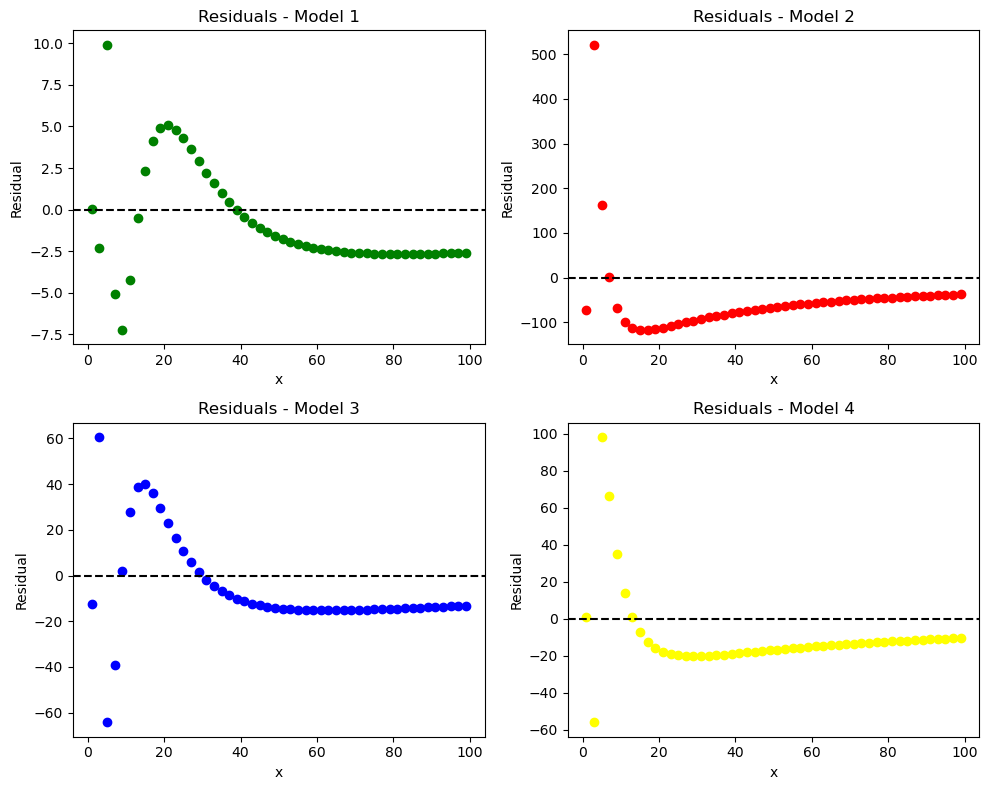

In [10]:
# predicted values
y_pred1 = model1(x, *popt1)
y_pred2 = model2(x, *popt2)
y_pred3 = model3(x, *popt3)
y_pred4 = model4(x, *popt4)

# residuals
residuals1 = y - y_pred1
residuals2 = y - y_pred2
residuals3 = y - y_pred3
residuals4 = y - y_pred4

plt.figure(figsize=(10, 8))
plt.subplot(2, 2, 1)
plt.scatter(x, residuals1, color='green')
plt.axhline(0, color='black', linestyle='--')
plt.title("Residuals - Model 1")
plt.xlabel("x")
plt.ylabel("Residual")

plt.subplot(2, 2, 2)
plt.scatter(x, residuals2, color='red')
plt.axhline(0, color='black', linestyle='--')
plt.title("Residuals - Model 2")
plt.xlabel("x")
plt.ylabel("Residual")

plt.subplot(2, 2, 3)
plt.scatter(x, residuals3, color='blue')
plt.axhline(0, color='black', linestyle='--')
plt.title("Residuals - Model 3")
plt.xlabel("x")
plt.ylabel("Residual")

plt.subplot(2, 2, 4)
plt.scatter(x, residuals4, color='yellow')
plt.axhline(0, color='black', linestyle='--')
plt.title("Residuals - Model 4")
plt.xlabel("x")
plt.ylabel("Residual")

plt.tight_layout()
plt.show()